In [1]:
import numpy as np
import json 
import torch
import torch.nn as nn  
import torch.nn.functional as F 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("Torch version:[%s]"%(torch.__version__))

Torch version:[2.0.1+cu117]


In [2]:
def torch2np(x_torch):
    return x_torch.detach().cpu().numpy()
def np2torch(x_np,device='cpu'):
    return torch.tensor(x_np,dtype=torch.float32,device=device)
print ("Done.")

Done.


In [3]:
class VariationalAutoEncoderClass(nn.Module):
    def __init__(self,
                 name     = 'VAE',
                 x_dim    = 120,
                 z_dim    = 2,
                 h_dims   = [64,32],
                 actv_enc = nn.LeakyReLU(),
                 actv_dec = nn.LeakyReLU(),
                 actv_out = None,
                 var_max  = None,
                 device   = 'cuda:0'
                 ):
        """
            Initialize VAE class
        """
        super(VariationalAutoEncoderClass,self).__init__()
        self.name     = name
        self.x_dim    = x_dim
        self.z_dim    = z_dim
        self.h_dims   = h_dims
        self.actv_enc = actv_enc
        self.actv_dec = actv_dec
        self.actv_out = actv_out
        self.var_max  = var_max
        self.device   = device
        # Initialize layers
        self.init_layers()
        self.init_params()
   
        
    def init_layers(self):
        """
            Initialize layers
        """
        self.layers = {}
        # Encoder part
        h_dim_prev = self.x_dim
        for h_idx,h_dim in enumerate(self.h_dims):
            self.layers['enc_%02d_lin'%(h_idx)]  = nn.Linear(h_dim_prev,h_dim,bias=True)
            self.layers['enc_%02d_actv'%(h_idx)] = self.actv_enc
            h_dim_prev = h_dim
        self.layers['z_mu_lin']  = nn.Linear(h_dim_prev,self.z_dim,bias=True)
        self.layers['z_var_lin'] = nn.Linear(h_dim_prev,self.z_dim,bias=True)
        # Decoder part
        h_dim_prev = self.z_dim
        for h_idx,h_dim in enumerate(self.h_dims[::-1]):
            self.layers['dec_%02d_lin'%(h_idx)]  = nn.Linear(h_dim_prev,h_dim,bias=True)
            self.layers['dec_%02d_actv'%(h_idx)] = self.actv_dec
            h_dim_prev = h_dim
        self.layers['out_lin'] = nn.Linear(h_dim_prev,self.x_dim,bias=True)
        # Append parameters
        self.param_dict = {}
        for key in self.layers.keys():
            layer = self.layers[key]
            if isinstance(layer,nn.Linear):
                self.param_dict[key+'_w'] = layer.weight
                self.param_dict[key+'_b'] = layer.bias
        self.vae_parameters = nn.ParameterDict(self.param_dict)
            
    def x_to_z_mu(self,x=torch.randn(2,784)):
        """
            x to z_mu
        """
        net = x
        for h_idx,_ in enumerate(self.h_dims):
            net = self.layers['enc_%02d_lin'%(h_idx)](net)
            net = self.layers['enc_%02d_actv'%(h_idx)](net)
        z_mu = self.layers['z_mu_lin'](net)
        return z_mu
    
    def x_to_z_var(self,x=torch.randn(2,784)):
        """
            x to z_var
        """
        net = x
        for h_idx,_ in enumerate(self.h_dims):
            net = self.layers['enc_%02d_lin'%(h_idx)](net)
            net = self.layers['enc_%02d_actv'%(h_idx)](net)
        net = self.layers['z_var_lin'](net)
        if self.var_max is None:
            net = torch.exp(net)
        else:
            net = self.var_max*torch.sigmoid(net)
        z_var = net
        return z_var

    def z_to_x_recon(self,z=torch.randn(2,16)):
        """
            z to x_recon
        """
        net = z
        for h_idx,_ in enumerate(self.h_dims[::-1]):
            net = self.layers['dec_%02d_lin'%(h_idx)](net)
            net = self.layers['dec_%02d_actv'%(h_idx)](net)
        net = self.layers['out_lin'](net)
        if self.actv_out is not None:
            net = self.actv_out(net)
        x_recon = net
        return x_recon

    def rapp_x_to_z_sample(self, x=torch.randn(2,784)):
        net_result = []
        net = x
        for h_idx,_ in enumerate(self.h_dims):
            net = self.layers['enc_%02d_lin'%(h_idx)](net)
            net1= net 
            net = self.layers['enc_%02d_actv'%(h_idx)](net) 
            net2 =net        
            net_result.append({"n_layer":h_idx+1,
                               "net":net1,
                               "actved":net2,
                               "name":'enc_%02d_lin'%(h_idx),
                               "actv_name":'enc_%02d_actv'%(h_idx)})
        return net_result 
        
    def x_to_z_sample(self,x=torch.randn(2,784)):
        """
            x to z_sample
        """
        z_mu,z_var = self.x_to_z_mu(x=x),self.x_to_z_var(x=x)
        eps_sample = torch.randn(size=z_mu.shape,dtype=torch.float32).to(self.device)
        z_sample   = z_mu + torch.sqrt(z_var+1e-10)*eps_sample
        return z_sample
    
    def x_to_x_recon(self,
                     x             = torch.randn(2,784),
                     STOCHASTICITY = True):
        """
            x to x_recon
        """
        if STOCHASTICITY:
            z_sample = self.x_to_z_sample(x=x)
        else:
            z_sample = self.x_to_z_mu(x=x)
        x_recon = self.z_to_x_recon(z=z_sample)
        return x_recon
    
    def sample_x(self,
                 n_sample = 5):
        """
            Sample x
        """
        z_sample = torch.randn(size=(n_sample,self.z_dim),dtype=torch.float32).to(self.device)
        return self.z_to_x_recon(z=z_sample),z_sample
    
    def init_params(self):
        """
            Initialize parameters
        """
        for key in self.layers.keys():
            layer = self.layers[key]
            if isinstance(layer,nn.Linear):
                nn.init.normal_(layer.weight,mean=0.0,std=0.01)
                nn.init.zeros_(layer.bias)
            elif isinstance(layer,nn.BatchNorm2d):
                nn.init.constant_(layer.weight,1.0)
                nn.init.constant_(layer.bias,0.0)
            elif isinstance(layer,nn.Conv2d):
                nn.init.kaiming_normal_(layer.weight)
                nn.init.zeros_(layer.bias)
 
    def loss_recon(self,
                   x               = torch.randn(2,784),
                   LOSS_TYPE       = 'L1',
                   recon_loss_gain = 1.0,
                   STOCHASTICITY   = True):
        """
            Recon loss
        """
        x_recon = self.x_to_x_recon(x=x,STOCHASTICITY=STOCHASTICITY)
        if (LOSS_TYPE == 'L1') or (LOSS_TYPE == 'MAE'):
            errs = torch.mean(torch.abs(x-x_recon),axis=1)
        elif (LOSS_TYPE == 'L2') or (LOSS_TYPE == 'MSE'):
            errs = torch.mean(torch.square(x-x_recon),axis=1)
        elif (LOSS_TYPE == 'L1+L2') or (LOSS_TYPE == 'EN'):
            errs = torch.mean(
                0.5*(torch.abs(x-x_recon)+torch.square(x-x_recon)),axis=1)
        else:
            raise Exception("VAE:[%s] Unknown loss_type:[%s]"%
                            (self.name,LOSS_TYPE))
        return recon_loss_gain*torch.mean(errs)
    
    def loss_kl(self,x=torch.randn(2,784)):
        """
            KLD loss
        """
        z_mu     = self.x_to_z_mu(x=x)
        z_var    = self.x_to_z_var(x=x)
        z_logvar = torch.log(z_var)
        errs     = 0.5*torch.sum(z_var + z_mu**2 - 1.0 - z_logvar,axis=1)
        return torch.mean(errs)
    
    def loss_total(self,
                   x               = torch.randn(2,784),
                   LOSS_TYPE       = 'L1+L2',
                   recon_loss_gain = 1.0,
                   STOCHASTICITY   = True,
                   beta            = 1.0):
        """
            Total loss
        """
        loss_recon_out = self.loss_recon(
            x               = x,
            LOSS_TYPE       = LOSS_TYPE,
            recon_loss_gain = recon_loss_gain,
            STOCHASTICITY   = STOCHASTICITY
        )
        loss_kl_out    = beta*self.loss_kl(x=x)
        loss_total_out = loss_recon_out + loss_kl_out
        info           = {'loss_recon_out' : loss_recon_out,
                          'loss_kl_out'    : loss_kl_out,
                          'loss_total_out' : loss_total_out,
                          'beta'           : beta}
        return loss_total_out,info
    
print ("Done.")

Done.


In [4]:
import matplotlib.pyplot as plt 
import json 
import os 
import copy
import sys 
sys.path.append("..")
rel_path = '../rapp/dataset_traj/manipulator_traj.json'
rel_path_novel = '../rapp/dataset_traj/manipulator_traj_one_step.json'
json_content = []
json_content_novel = []

cnt = 0
for line in open(rel_path_novel, 'r'):
    json_content_novel.append(json.loads(line))

for line in open(rel_path, 'r'):
    json_content.append(json.loads(line))
    # print("[Number of trajectory: {}] [Number of step: {}] [Joint value: {}]".format(json.loads(line)["num_traj"], json.loads(line)["num_step"], json.loads(line)["q"]))

In [5]:
preprocessd_data = []
stacked = np.array([])
for idx in range(999):
    each_traj = json_content[20*idx:20*(idx+1)]
    for traj_idx, traj in enumerate(each_traj):
        stacked = np.append(stacked, traj["q"])
    preprocessd_data.append(stacked)
    stacked = np.array([])

preprocessd_data = np.array(preprocessd_data)

In [6]:
preprocessd_novel_data = []
stacked = np.array([])
for idx in range(999):
    each_traj = json_content_novel[20*idx:20*(idx+1)]
    for traj_idx, traj in enumerate(each_traj):
        stacked = np.append(stacked, traj["q"])
    preprocessd_novel_data.append(stacked)
    stacked = np.array([])

preprocessd_novel_data = np.array(preprocessd_novel_data)

In [17]:
# Trianing Dataset
print("Shape: {}".format(preprocessd_data.shape))
preprocessd_data[0]

Shape: (999, 120)


array([-0.52149033, -1.1343436 ,  2.56500167, -1.43076642,  1.04930758,
        3.14155149, -0.71582273, -1.10175369,  2.44731255, -1.34568359,
        0.85497515,  3.14157949, -0.83676264, -1.04510822,  2.28406158,
       -1.23909407,  0.73403518,  3.14160219, -0.87049025, -0.98710248,
        2.13603107, -1.14907496,  0.70030753,  3.14160963, -0.84754605,
       -0.94412584,  2.0323831 , -1.08839977,  0.72325172,  3.14160452,
       -0.80394275, -0.90976482,  1.95185031, -1.04222135,  0.76685502,
        3.14159549, -0.77227926, -0.87012895,  1.86083032, -0.99083295,
        0.7985185 ,  3.14158943, -0.76355282, -0.81851644,  1.74455549,
       -0.92616953,  0.80724493,  3.14158783, -0.75814516, -0.76217797,
        1.61977813, -0.85772999,  0.81265257,  3.14158685, -0.72092658,
       -0.72328637,  1.53463502, -0.81147409,  0.84987115,  3.14158036,
       -0.62057026, -0.71772225,  1.52250955, -0.804903  ,  0.95022751,
        3.14156477, -0.44852074, -0.72324296,  1.53454067, -0.81

In [16]:
# Test Datset
print("Shape: {}".format(preprocessd_novel_data.shape))
preprocessd_novel_data[0]

Shape: (999, 120)


array([-0.260633  , -1.00764162,  1.29837817,  1.28005979,  1.57079552,
       -0.26063326, -0.25046582, -0.97095426,  1.2312389 ,  1.31051172,
        1.57079558, -0.25046668, -0.24029864, -0.9342669 ,  1.16409964,
        1.34096365,  1.57079564, -0.2403001 , -0.23013146, -0.89757955,
        1.09696037,  1.37141557,  1.5707957 , -0.23013352, -0.21996428,
       -0.86089219,  1.0298211 ,  1.4018675 ,  1.57079576, -0.21996695,
       -0.20979711, -0.82420484,  0.96268184,  1.43231942,  1.57079582,
       -0.20980037, -0.19962993, -0.78751748,  0.89554257,  1.46277135,
        1.57079588, -0.19963379, -0.18946275, -0.75083012,  0.8284033 ,
        1.49322328,  1.57079594, -0.18946722, -0.17929557, -0.71414277,
        0.76126404,  1.5236752 ,  1.570796  , -0.17930064, -0.16912839,
       -0.67745541,  0.69412477,  1.55412713,  1.57079606, -0.16913406,
       -0.15896122, -0.64076805,  0.62698551,  1.58457906,  1.57079612,
       -0.15896749, -0.14879404, -0.6040807 ,  0.55984624,  1.61

In [18]:
n_train = preprocessd_data.shape[0]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
x_train_torch = np2torch(preprocessd_data, device)
x_train_torch_novel = np2torch(preprocessd_novel_data, device)

V = VariationalAutoEncoderClass(
    name     = 'VAE',
    x_dim    = 120,
    z_dim    = 2,
    h_dims   = [256,256],
    actv_enc = nn.ReLU(),
    actv_dec = nn.ReLU(),
    actv_out = None,
    var_max  = 0.1,
    device   =device,
    ).to(device)
print ("[%s] instantiated"%(V.name))
# Hyperparameters
n_epoch,print_every,batch_size,plot_every = 10000,1,128,50
n_it = (n_train//batch_size) + 1 # number of iterations
optm = torch.optim.Adam(
    params = V.parameters(),
    lr     = 0.001,
    betas  = (0.9,0.99),  # (0.9, 0.999)
    eps    = 1e-4        # 1e-8
)

[VAE] instantiated


In [12]:
TRAIN = True 
if TRAIN:
    for epoch in range(n_epoch):
        zero_to_one = float(epoch/(n_epoch-1))
        if epoch >= 500: beta = 0.01
        else:           beta = 0.0
        loss_recon_sum,loss_kl_sum,loss_total_sum,n_batch_sum = 0.0,0.0,0.0,0
        rand_idxs = np.random.permutation(n_train)
        for it in range(n_it):
            batch_idx     = rand_idxs[it*batch_size:(it+1)*batch_size]
            x_batch_torch = x_train_torch[batch_idx,:]
            n_batch       = x_batch_torch.shape[0]
            # Update
            total_loss_out,loss_info = V.loss_total(
                x               = x_batch_torch,
                LOSS_TYPE       = 'L1+L2',
                recon_loss_gain = 10.0,
                beta            = beta*zero_to_one,
                STOCHASTICITY   = True)
            optm.zero_grad(); total_loss_out.backward(); optm.step()
            # Errors
            loss_total_sum = loss_total_sum + n_batch*loss_info['loss_total_out']
            loss_recon_sum = loss_recon_sum + n_batch*loss_info['loss_recon_out']
            loss_kl_sum    = loss_kl_sum + n_batch*loss_info['loss_kl_out']
            n_batch_sum    = n_batch_sum + n_batch
        loss_total_avg = loss_total_sum / n_batch_sum
        loss_recon_avg = loss_recon_sum / n_batch_sum
        loss_kl_avg    = loss_kl_sum / n_batch_sum
        # Print
        print ("[%d/%d] total:[%.3f] recon:[%.3f] kl:[%.3f]"%
            (epoch,n_epoch,loss_total_avg,loss_recon_avg,loss_kl_avg))
        if (epoch+1)%200==0 or (epoch+1)==n_epoch:
            torch.save(V.state_dict(),"weights/"+"rapp_less_data_vae_{}steps.pth".format(epoch+1))


[0/10000] total:[19.866] recon:[19.866] kl:[0.000]
[1/10000] total:[19.326] recon:[19.326] kl:[0.000]
[2/10000] total:[16.629] recon:[16.629] kl:[0.000]
[3/10000] total:[7.923] recon:[7.923] kl:[0.000]
[4/10000] total:[3.164] recon:[3.164] kl:[0.000]
[5/10000] total:[1.653] recon:[1.653] kl:[0.000]
[6/10000] total:[1.269] recon:[1.269] kl:[0.000]
[7/10000] total:[0.982] recon:[0.982] kl:[0.000]
[8/10000] total:[0.884] recon:[0.884] kl:[0.000]
[9/10000] total:[0.837] recon:[0.837] kl:[0.000]
[10/10000] total:[0.803] recon:[0.803] kl:[0.000]
[11/10000] total:[0.790] recon:[0.790] kl:[0.000]
[12/10000] total:[0.785] recon:[0.785] kl:[0.000]
[13/10000] total:[0.782] recon:[0.782] kl:[0.000]
[14/10000] total:[0.781] recon:[0.781] kl:[0.000]
[15/10000] total:[0.778] recon:[0.778] kl:[0.000]
[16/10000] total:[0.778] recon:[0.778] kl:[0.000]
[17/10000] total:[0.781] recon:[0.781] kl:[0.000]
[18/10000] total:[0.777] recon:[0.777] kl:[0.000]
[19/10000] total:[0.778] recon:[0.778] kl:[0.000]
[20/

In [13]:
# Reconstruction test 
z_test = torch.randn(2).to(device)
x_recon = V.z_to_x_recon(z=z_test)
print(x_recon)

tensor([-0.5134, -1.1413,  2.5775, -1.4368,  1.0563,  3.1550, -0.9892, -1.0645,
         2.3356, -1.2707,  0.5863,  3.1599, -1.1929, -0.9459,  2.0501, -1.0875,
         0.3740,  3.1562, -1.2115, -0.8394,  1.7856, -0.9449,  0.3672,  3.1550,
        -1.1109, -0.8145,  1.7354, -0.9235,  0.4572,  3.1589, -1.0201, -0.7812,
         1.6591, -0.8834,  0.5536,  3.1609, -0.9677, -0.7178,  1.4927, -0.8007,
         0.6168,  3.1594, -0.8985, -0.6780,  1.4414, -0.7570,  0.6721,  3.1551,
        -0.8005, -0.6553,  1.3804, -0.7233,  0.7714,  3.1567, -0.7052, -0.6399,
         1.3675, -0.7057,  0.8656,  3.1568, -0.6166, -0.5973,  1.2764, -0.6636,
         0.9598,  3.1593, -0.6005, -0.5304,  1.1665, -0.5932,  0.9654,  3.1398,
        -0.6564, -0.5048,  1.0645, -0.5651,  0.9133,  3.1367, -0.7212, -0.4495,
         0.9558, -0.4993,  0.8532,  3.1578, -0.7645, -0.3418,  0.7299, -0.3873,
         0.8088,  3.1611, -0.7856, -0.2203,  0.4655, -0.2533,  0.7792,  3.1609,
        -0.7883,  0.0108, -0.0426,  0.00

In [20]:
LOAD_WEIGHTPATH ='./weights/rapp_small_data_vae_10000steps.pth'

print("Weight: {} Load.".format(LOAD_WEIGHTPATH))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

V = VariationalAutoEncoderClass(
    name     = 'VAE',
    x_dim    = 120,
    z_dim    = 2,
    h_dims   = [256,256],
    actv_enc = nn.ReLU(),
    actv_dec = nn.ReLU(),
    actv_out = None,
    var_max  = 0.1,
    device   =device,
    ).to(device)
print ("[%s] instantiated"%(V.name))

V.load_state_dict(torch.load(LOAD_WEIGHTPATH))

Weight: ./weights/rapp_small_data_vae_10000steps.pth Load.
[VAE] instantiated


<All keys matched successfully>

### Playground 

In [21]:
""" Training data """
x_recon_xx = V.x_to_x_recon(x_train_torch[1])
# comparision: new data vs training data
hdim_result_recon = V.rapp_x_to_z_sample(x=x_recon_xx)
hdim_result_data = V.rapp_x_to_z_sample(x=x_train_torch[1])
for result_data, result_recon in zip(hdim_result_data, hdim_result_recon): 
    print(result_data["name"],np.var(torch2np(result_data["net"])-torch2np(result_recon["net"])))
    print(result_data["actv_name"],np.var(torch2np(result_data["actved"])-torch2np(result_recon["actved"])))

enc_00_lin 0.01208734
enc_00_actv 0.0014192852
enc_01_lin 0.0076322444
enc_01_actv 0.0012224517


In [22]:
""" Unseen data """
x_recon_xx_novel = V.x_to_x_recon(x_train_torch_novel[1])
# comparision: new data vs training data
hdim_result_recon = V.rapp_x_to_z_sample(x=x_recon_xx_novel)
hdim_result_data = V.rapp_x_to_z_sample(x=x_train_torch_novel[1])
for result_data, result_recon in zip(hdim_result_data, hdim_result_recon): 
    print(result_data["name"],np.var(torch2np(result_data["net"])-torch2np(result_recon["net"])))
    print(result_data["actv_name"],np.var(torch2np(result_data["actved"])-torch2np(result_recon["actved"])))

enc_00_lin 1.3923512
enc_00_actv 0.79498804
enc_01_lin 176.45566
enc_01_actv 0.08223786


In [28]:
# MSE Measure

recon_loss=[]
for i in range(999):
    recon_q = V.x_to_x_recon(x=x_train_torch[i])
    recon_loss.append(F.mse_loss(recon_q, x_train_torch[i]).item())
original_uncertainty = np.array(recon_loss).reshape(-1,1)
original_uncertainty.shape

novel_recon_loss = []
for i in range(999):
    recon_q = V.x_to_x_recon(x=x_train_torch_novel[i])
    novel_recon_loss.append(F.mse_loss(recon_q, x_train_torch_novel[i]).item())
novel_uncertainty = np.array(novel_recon_loss).reshape(-1,1)

In [29]:
total_uncertainty = np.concatenate((original_uncertainty, novel_uncertainty),axis=0)

In [30]:
# RAPP Measure

recon_loss = []
for i in range(999):
    loss = 0 
    x_recon = V.x_to_x_recon(x_train_torch[i])
    original_hidden_value = V.rapp_x_to_z_sample(x=x_recon)
    recon_hidden_value = V.rapp_x_to_z_sample(x=x_train_torch[i])
    for i, j in zip(original_hidden_value, recon_hidden_value):
        loss += F.mse_loss(i["actved"],j["actved"])
    recon_loss.append(loss.item())

original_uncertainty = np.array(recon_loss).reshape(-1,1)

In [31]:
recon_loss = []
for i in range(999):
    loss = 0 
    x_recon_novel = V.x_to_x_recon(x_train_torch_novel[i])
    original_hidden_value = V.rapp_x_to_z_sample(x=x_recon_novel)
    recon_hidden_value = V.rapp_x_to_z_sample(x=x_train_torch_novel[i])
    for i, j in zip(original_hidden_value, recon_hidden_value):
        loss += F.mse_loss(i["actved"],j["actved"])
    recon_loss.append(loss.item())

novelty_uncertainty = np.array(recon_loss).reshape(-1,1)


In [27]:
# comparison: recon data vs training data 
z_test  = torch.randn(1,2).to(device)
x_recon = V.z_to_x_recon(z=z_test)
hdim_result_recon = V.rapp_x_to_z_sample(x=x_recon)
hdim_result_data = V.rapp_x_to_z_sample(x=x_train_torch[0])
for result_data, result_recon in zip(hdim_result_data, hdim_result_recon):
    print(result_data["name"],np.var(torch2np(result_data["net"])-torch2np(result_recon["net"])))

enc_00_lin 0.2463985
enc_01_lin 0.17924717


In [32]:
total_hidden_uncertainty = np.concatenate((original_uncertainty, novelty_uncertainty),axis=0)

In [33]:
# comparision: new data vs training data
x_recon = torch.zeros(size=(1,120)).to(device)
hdim_result_recon = V.rapp_x_to_z_sample(x=x_recon)
hdim_result_data = V.rapp_x_to_z_sample(x=x_train_torch[1])
for result_data, result_recon in zip(hdim_result_data, hdim_result_recon):
    print(result_data["name"],np.var(torch2np(result_data["net"])-torch2np(result_recon["net"])))

enc_00_lin 3.6994004
enc_01_lin 0.43728432


In [34]:
# comparision: training data vs training data 
hdim_result_recon = V.rapp_x_to_z_sample(x=x_train_torch[3])
hdim_result_data = V.rapp_x_to_z_sample(x=x_train_torch[1])
for result_data, result_recon in zip(hdim_result_data, hdim_result_recon):
    print(result_data["name"],np.var(torch2np(result_data["net"])-torch2np(result_recon["net"])))

enc_00_lin 0.26336202
enc_01_lin 0.096004464


### AUROC Measure

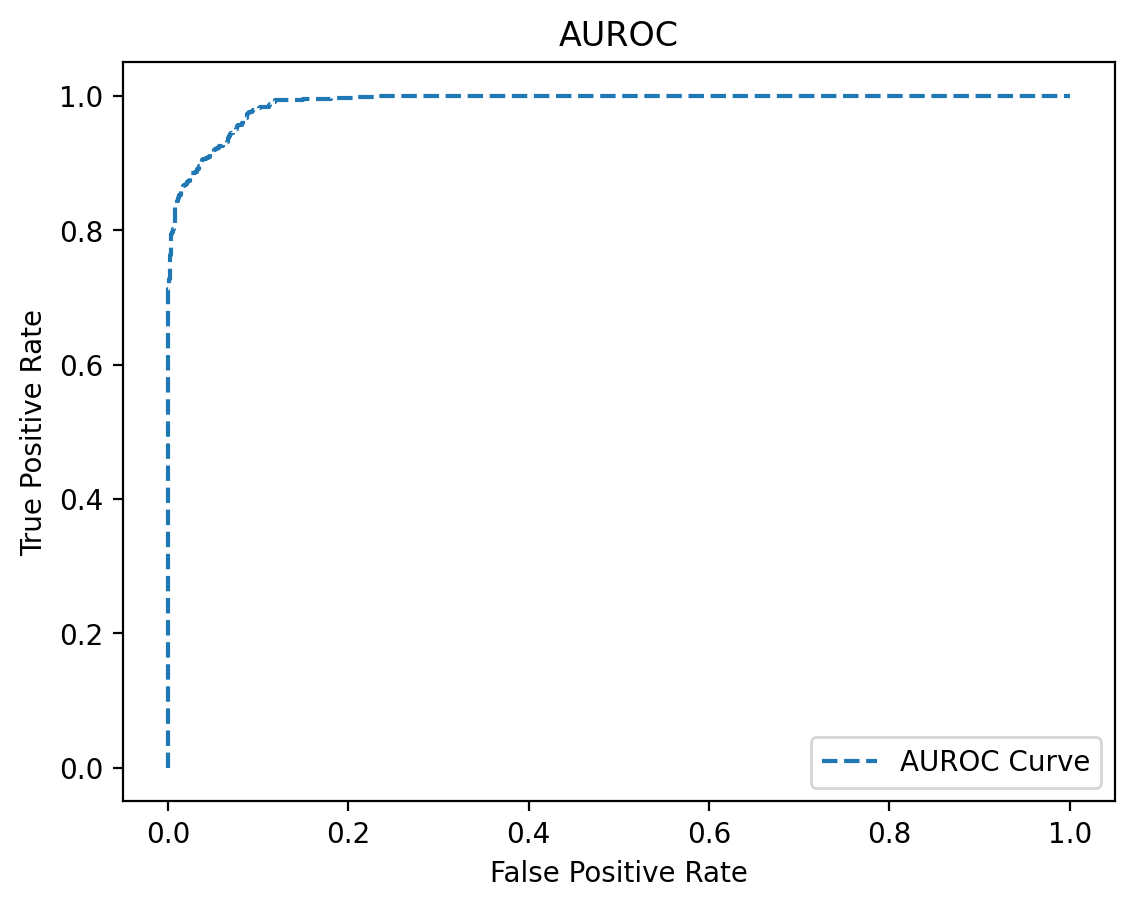

AUROC Score: 0.9900681462243024


In [44]:
trained_label = np.zeros(999)
novelty_label = np.ones(999)
total_label   = np.concatenate((trained_label, novelty_label), axis=0)


recon_loss = []
for i in range(999):
    loss = 0 
    x_recon = V.x_to_x_recon(x_train_torch[i])
    original_hidden_value = V.rapp_x_to_z_sample(x=x_recon)
    recon_hidden_value = V.rapp_x_to_z_sample(x=x_train_torch[i])
    for i, j in zip(original_hidden_value, recon_hidden_value):
        loss += F.mse_loss(i["net"],j["net"])
    recon_loss.append(loss.item())

original_uncertainty = np.array(recon_loss).reshape(-1,1)



novel_recon_loss = []
for i in range(999):
    loss = 0 
    x_recon_novel = V.x_to_x_recon(x_train_torch_novel[i])
    original_hidden_value = V.rapp_x_to_z_sample(x=x_recon_novel)
    recon_hidden_value = V.rapp_x_to_z_sample(x=x_train_torch_novel[i])
    for origin_h, recon_h in zip(original_hidden_value, recon_hidden_value):
        loss += F.mse_loss(origin_h["net"],recon_h["net"])
    novel_recon_loss.append(loss.item())

novelty_uncertainty = np.array(novel_recon_loss).reshape(-1,1)

total_hidden_uncertainty = np.concatenate((original_uncertainty, novelty_uncertainty),axis=0)

from sklearn import metrics
from sklearn.metrics import precision_recall_curve,auc, roc_auc_score, roc_curve 

fpr, tpr, thresholds = metrics.roc_curve(total_label, total_hidden_uncertainty)
auc = roc_auc_score(total_label, total_hidden_uncertainty)
plt.plot(fpr, tpr, linestyle='--', label='AUROC Curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
# plt.title("AUROC: Unseen Data")
plt.title("AUROC")
plt.show()
print("AUROC Score: {}".format(auc))



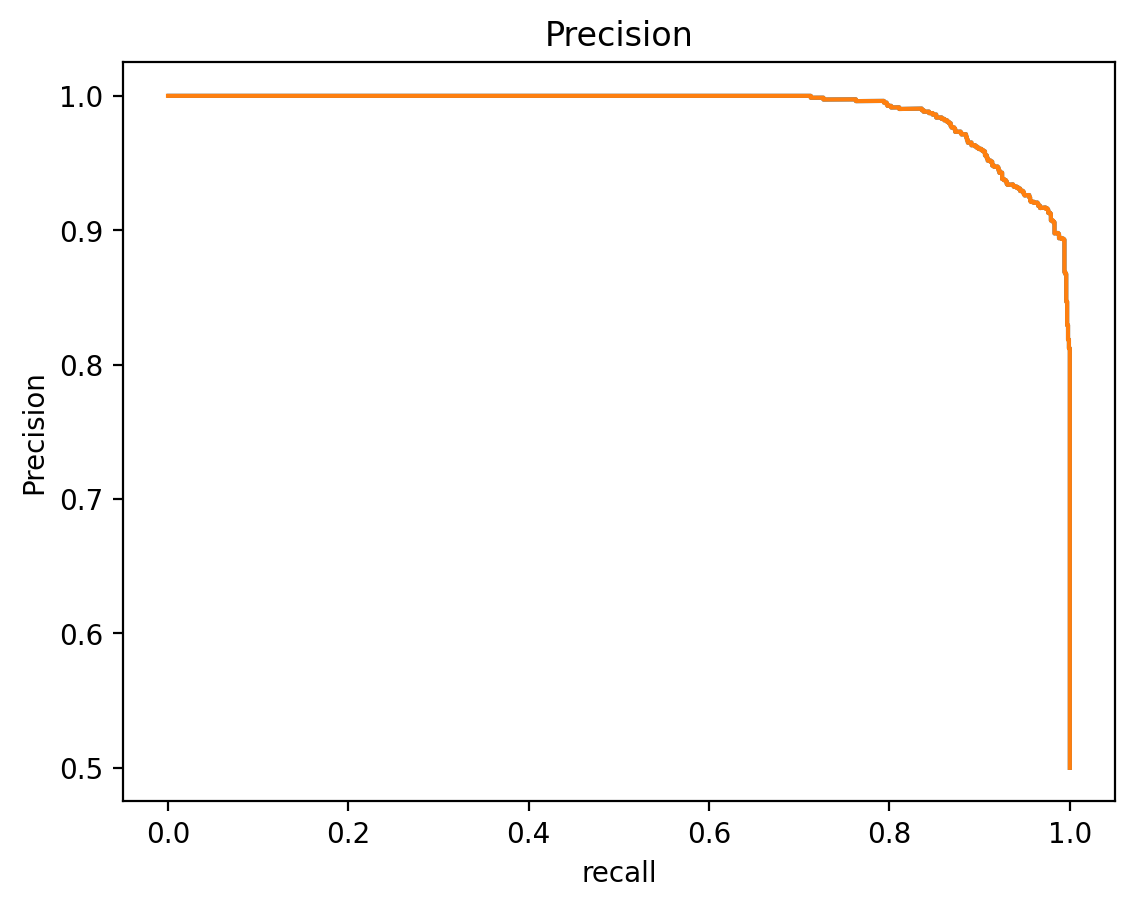

In [45]:
precision, recall, thresholds = precision_recall_curve(total_label, total_hidden_uncertainty)
plt.plot(recall[:-1],precision[:-1])
plt.title("Precision")
plt.plot(recall, precision)
plt.xlabel("recall")
plt.ylabel("Precision")
plt.show()